In [1]:
from textwrap import dedent

def code_hider():
    """Make a button in the jupyter notebook to hide all code"""
    # Stolen from stackoverflow... forget which question
    # I would really like these buttons for every individual cell.. but I don't know how
    from IPython.display import HTML    # Please keep here, don't want hax to depend on ipython!
    return HTML(dedent('''
                       <script>
                       code_show=true
                       function code_toggle() {
                        if (code_show){
                        $('div.input').hide();
                          } else {
                        $('div.input').show();
                        }
                        code_show = !code_show
                       }
                       //$( document ).ready(code_toggle);
                       </script>
                       <form action="javascript:code_toggle()"><input type="submit"
                       value="Show/hide  all code in this notebook"></form>'''))

code_hider()


In [2]:
# Boilerplate startup code
%matplotlib notebook
%matplotlib inline
import math
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import codecs
from datetime import datetime
from scipy.ndimage.filters import gaussian_filter

matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (15.0, 5.0)    # resize plots


def read_file(file):
    COMMENT_CHAR = '#'
    columns = []
    with file as td:
        for line in td:
        
            # find the commented lines
            if line[0] == COMMENT_CHAR or line[0] =='0':
                if ('dure de comptage:') in line:
                    splitvalues= line.split("e:  ")
                    date_str= splitvalues[1][0:-2]
                    
                    time= datetime.strptime(date_str, '%H:%M:%S')- datetime.strptime("1900:1:1",'%Y:%m:%d')
            # when we seethe first line that doesn't start with 
            # COMMENT_CHAR, we pass the remaining lines of the 
            # file to pandas.read_table and break our loop
            else:
                _dfs = [
                        pd.DataFrame([line.split()],  dtype=int),
                        pd.read_table(td, sep='\s+', names=['channel', 'N'], header=None, engine='python')
                        ]
                df = pd.concat(_dfs, ignore_index=True)
    df['NEr'] = [math.sqrt(y)/time.seconds for y in df.N]

    df.N = df.N/time.seconds
    df = df.dropna(thresh=2)
    return df

cs_lines = [661] #keV
co_lines = [1173, 1332]
na_lines = [511, 1274]

/data/anaconda3/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Calibration du detectecteurs avec des sources radiactives

## Bout de la manip

Dans cette experience vous allez apprendre a calibrer un detecteur. Il faut obtenir deux choses: la echelle de le detecteur et son resolution.

### Consignes de sécurité

Dans ce laboratoire, vous manipulerez des sources radiactives. Voici quelques règles élémentaires de sécurité:

- Manipulez toujours les sources avec la pince prévue à cet effet
- Ne laissez jamais les sources exposées à l'air libre
- Les sources ne peuvent sortir du labo
- Lavez-vous les mains en sortant du labo

Vous êtes responsables des sources; en particulier, vous les retrouverez vous-mêmes en cas de perte (dussiez-vous y passer la nuit).



## Dispositif expérimental

### Sources étudiées

Le tableau ci-dessous reprend quelques propriétés des sources que vous étudierez au laboratoire.

<table>
    <tr><th>Mode de désintégration</th><th style="text-align: left">$E_\gamma$</th></tr>
    <tr><td style="text-align: left">${}^{137}\mathrm{Cs}\to\mathrm{Ba}\,e^-\bar\nu_e\,\gamma$</td><td style="text-align: left">$661\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{133}\mathrm{Ba}\to\mathrm{Cs}\,\gamma$</td><td style="text-align: left">$288\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{60}\mathrm{Co}\to\mathrm{Ni}\,e^-\bar\nu_e\,\gamma\gamma$</td><td style="text-align: left">$1173$ et $1332\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{22}\mathrm{Na}\to\mathrm{Ne}\,e^+\nu_e\,\gamma$</td><td style="text-align: left">$1274\text{ keV}$</td></tr>
    <tr><td style="text-align: left">${}^{22}\mathrm{Na}\to\mathrm{Ne}\,e^+\nu_e\,\gamma$</td><td style="text-align: left">$511\text{ keV}$ (masse de l'électron)</td></tr>
</table>



 Vous aurez à votre disposition au labo un scintillateur constitué d'un cristal scintillateur NaI, relié à un tube photomultiplicateur. Les scintillateurs sont des matériaux qui émettent de la lumière quand ils sont traversés par des particules ionisantes. Dans notre montage, cette lumière excite des électrons dans le photomultiplicateur, qui amplifie ensuite très fortement le courant produit ([source de l'image](https://commons.wikimedia.org/wiki/File:Tubephotomultiplicateur.svg)):

![Tube PM](images/Photomultiplicateur.png)

Les tubes PM se basent sur une grande différence de potentiel appliquée entre des électrodes de forme spéciale (dynodes). Vous les étudierez plus en détail au [cours de physique des particules](http://www.iihe.ac.be/~lfavart/cours.html). Le signal produit est proportionnel à l'énergie des particules qui traversent le scintillateur.

Dans le montage utilisé au laboratoire, le courant créé par les électrons dans le PM est amplifié une seconde fois, transformé en un signal numérique par un ADC (convertisseur analogique-digital), qui est enfin lu par un ordinateur. Les valeurs fournies par l'ADC représentent l'énergie déposée dans le PM, dans des unités arbitraires.

Enfin, signalons qu'afin qu'il ne détecte que les rayons $\gamma$, une plaque métallique est placée à l'avant du scintillateur. Celle-ci stoppe efficacement les électrons et les particules $\alpha$.

##  Manipulation à effectuer

**Attention**
La plus grande partie de cette manipulation consiste en l'analyse des données que vous prendrez. Faites-le directement au labo pour pouvoir profiter de la présence des assistants.

1. Prenez des données pour cinq configurations: pour le bruit de fond et avec les sources de ${}^{137}\mathrm{Cs}$, ${}^{133}\mathrm{Ba}$, ${}^{60}\mathrm{Co}$, ${}^{22}\mathrm{Na}$ et la source inconnue. L'accumulation d'une quantité suffisante d'événements de bruit de fond prenant du temps, commencez par utiliser les sources.

1. Comparez le bruit du fond  mesure en utilisant les scalers avec les resultats que vous avez obtenu dans le cas du compteur Geiger.

** Analise des donnees **
1. Selectionez les pics dans votre mesures et ajustez une function Gauss pour avoir la moyen du pics et aussi leur largeure.

1. Calibrez le détecteur en trouvant la relation entre l'énergie du photon incident et l'unité arbitraire du système numérique. 

1. Determinez la resolution (absolu et relative) du detecteur en function d'energie et essayer de comprendre le comportment.


1. Déduisez-en l'énergie des pics non utilisés dans la calibration (utilisez un ajustement), et comparez ces résultats à la littérature.

1. En plus des pics de désintégration, les spectres comportent des contributions dues à la diffusion Compton des photons incidents. Identifiez-les et interprétez.

1. Vous disposez de cinq mesures du pic du plomb (une pour chaque spectre). (a) Peut-on les considérer comme indépendantes ?  Comparez les mesures et interpretez les resultats.

1. Vous avez manipulé des isotopes radioactifs. Comment sont-ils produits ? Peut-on les trouver dans la nature ?

Si vous désirez étendre votre analyse, voici quelques idées (*):

- Trouvez l'origine du pic visible à 1750 keV dans le spectre du ${}^{22}\mathrm{Na}$
- Utilisez le bruit de fond de manière originale
- Réalisez un ajustement unique pour les trois pics du ${}^{133}\mathrm{Ba}$ qui se superposent
- Mesurez l'âge d'une des sources

(\*) Si vous essayez, que ça ne fonctionne pas et que vous pouvez expliquer ce qui rend la mesure impossible, c'est un bon point à inclure dans votre rapport.

## Éléments théoriques

Dans la manipulation sur le compteur Geiger, vous avez déjà eu l'occasion d'observer la désintégration de noyaux instables. Pour rappel, quatre types de désintégrations existent:

* Désintégration $\alpha$ (${}_Z^AX\to {}_{Z-2}^{A-2}Y\,\mathrm{He}$)
* Désintégration $\gamma$ ($X^*\to X\,\gamma$)
* Désintégrations $\beta^+$ (${}^A_ZX \to {}^{A+1}_{Z-1}Y \,e^+\, \nu_e$) et $\beta^-$ (${}^A_ZX \to {}^{A-1}_{Z+1}Y \,e^-\, \bar\nu_e$)
* Éjection d'un neutron: ${}^AX\to {}^{A-1}X\,n$

Dans cette manipulation, nous allons étudier les particules produites lors des désintégrations, et en particulier les photons.


Comme vous avez déjà eu l'occasion de l'observer, la désintégration d'un noyau est un phénomène fondamentalement aléatoire. Cependant, certaines des propriétés de ce processus sont au contraire constantes: c'est notamment le cas de l'énergie du photon dans une désintégration $\gamma$ ($X^*\to X\,\gamma$). Celle-ci peut être prédite par un calcul simple: dans l'approximation où l'impulsion du noyau $X$ est négligeable, on obtient:

$$ E_\gamma = m_{X} - m_{X^*}, $$

où l'on a utilisé des unités telles que $c=1$.

L'énergie typique produite lors d'une désintégration est grande: de l'ordre de 100 keV (kiloélectronvolt). Par comparaison, l'énergie nécessaire pour ioniser un atome d'hydrogène est de 13,6 eV. C'est cette différence qui rend les bombes nucléaires bien plus dévastatrices que leurs homologues chimiques.

### Canaux de désintégration et spectre en énergie

Un même noyau peut souvent se désintégrer de plusieurs façons différentes, qu'on appelle *canaux*. À chaque canal est associé une probabilité, le *rapport de branchement*. La somme de tous les rapports de branchements est égale à 1.

Si l'on se concentre sur la probabilité d'émettre des particules d'énergie donnée (on parle de leur *spectre en énergie*)  et qu'on la porte en graphique, on obtient des pics aux valeurs correspondant aux différences de masses:

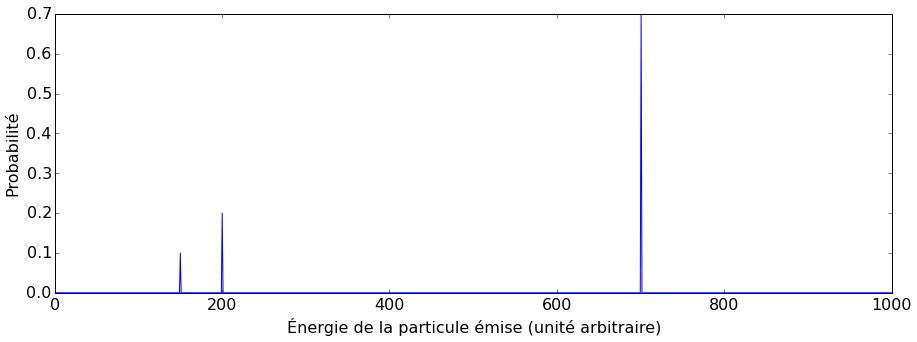

In [3]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
plt.plot(energie, spectre)
plt.xlabel("Énergie de la particule émise (unité arbitraire)")
plt.ylabel("Probabilité")

Dans l'exemple ci-dessus, on a trois canaux de désintégration avec des probabilités de 70%, 20% et 10%, correspondant chacun à un pic. Dans la réalité, un noyau peut posséder plusieurs dizaines de canaux de désintégration; ceux-ci (ainsi que les rapports de branchement associés) sont répertoriés dans des ouvrages de référence.

### Chaînes de désintégration

Il arrive souvent qu'un noyau se désintègre vers un état instable d'un autre noyau. Ce dernier se désintègre alors à son tour, ajoutant des lignes au spectre du premier. C'est ainsi qu'on observe des photons dans les produits de désintégration du cobalt 60. La première désintégration est une $\beta^-$:

$$ {}^{60}\mathrm{Co} \to \mathrm{Ni}^{**} e^- \bar\nu_e$$

Le noyau de nickel excité ($\mathrm{Ni}^{**}$) se désexcite ensuite en deux étapes, émettant à chaque fois un photon:

$$ \mathrm{Ni}^{**} \to \mathrm{Ni}^* \gamma \to \mathrm{Ni} \,\gamma\gamma $$

Ces deux dernières réactions ayant lieu en un temps très court (de l'ordre de la picoseconde), les pics correspondants sont souvent inclus dans le spectre du cobalt 60. Si on reprend notre exemple et qu'on suppose que le canal à 70% mêne à un noyau qui peut se désexciter de deux façons différentes, on obtient:

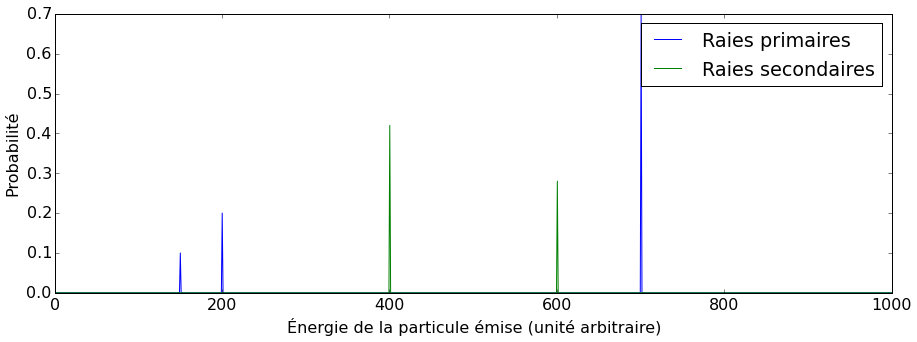

In [4]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
plt.plot(energie, spectre)
spectre = np.zeros(1000)
spectre[600] = 0.7*0.4
spectre[400] = 0.7*0.6
plt.plot(energie, spectre)
plt.legend(("Raies primaires", "Raies secondaires"))
plt.xlabel("Énergie de la particule émise (unité arbitraire)")
plt.ylabel("Probabilité")

### Effets expérimentaux

Différents effets expérimentaux affectent la distribution mesurée, et leur compréhension est importante pour l'interprétation physique des données que vous allez prendre.

#### Résolution du détecteur

L'effet le plus important est que notre montage ne permet pas une mesure infiniment précise de l'énergie du photon incident. De ce fait, les pics très marqués dans le spectre se transforment en des courbes plus larges:

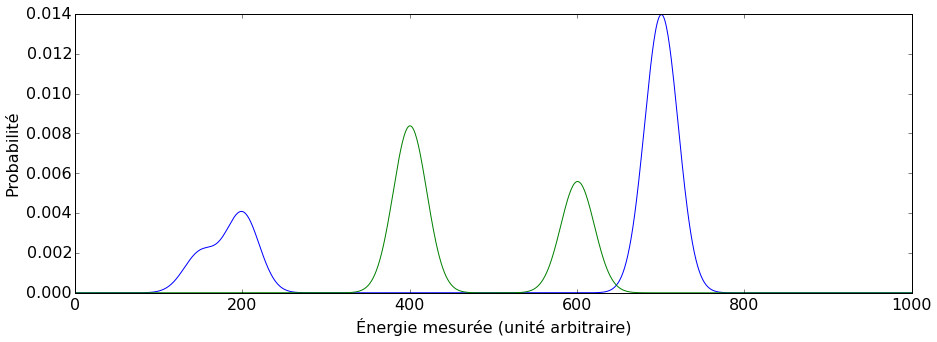

In [5]:
energie = np.linspace(0, 1000, 1000)
spectre1 = np.zeros(1000)
spectre1[700] = 0.7
spectre1[200] = 0.2
spectre1[150] = 0.1
plt.plot(energie, gaussian_filter(spectre1, 20))
spectre2 = np.zeros(1000)
spectre2[600] = 0.7*0.4
spectre2[400] = 0.7*0.6
plt.plot(energie, gaussian_filter(spectre2, 20))
plt.xlabel("Énergie mesurée (unité arbitraire)")
plt.ylabel("Probabilité")

La largeur des pics est données par la *résolution en énergie* du système, $\Delta E_\gamma$. Il s'agit de la même incertitudes que celles calculée en utilisant les formules de propagation, mais on aura ici un très grand nombre de mesures, ce qui permettra des statistiques précises.

La résolution en énergie d'un PM n'est pas constante. Dans le cas présent, une bonne approximation est:

$$ \frac{\Delta E_\gamma}{E_\gamma} = \text{constante}, $$

sauf pour les petites énergies.

#### Bruit de fond

Un deuxième effet expérimental important est la présence de bruit de fond, causé par deux facteurs principaux:

- **L'environnement**: Notre système n'étant pas totalement isolé du reste du monde, il détectera aussi des particules ne provenant pas de la source. En particulier, le coffrage de plomb qui l'entoure est devenu radioactif suite à une exposition prolongée aux sources. La seule présence dans la pièce d'une personne ayant subi un examen de radiologie peut empêcher le système de fonctionner correctement; activer le WiFi sur un ordinateur modifie également le bruit.

- **L'électronique**: Le système électronique utilisé n'est pas infaillible, et des fluctuations dans les différents composants peuvent provoquer des fausses détections. On s'en prémunit autant que possible en utilisant un seuil (comme pour le trigger de l'oscilloscope).

La combinaison des différents bruits de fond s'ajoute aux pics dûs à la source que l'on souhaite mesurer, avec une contribution qui décroît typiquement avec l'énergie mesurée:

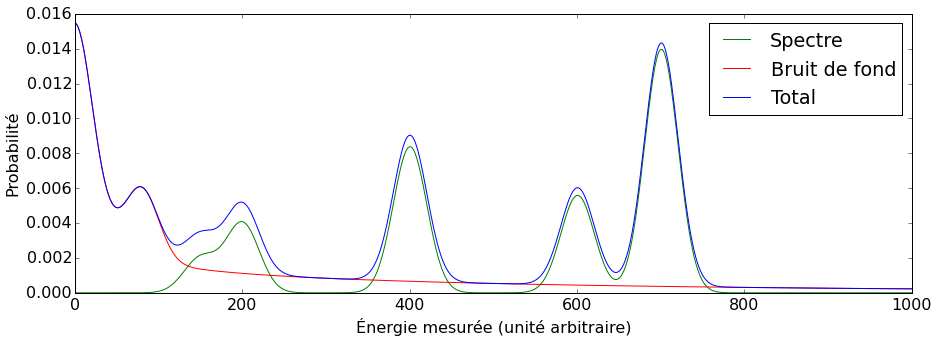

In [6]:
energie = np.linspace(0, 1000, 1000)
spectre = np.zeros(1000)
spectre[700] = 0.7
spectre[200] = 0.2
spectre[150] = 0.1
spectre[600] = 0.7*0.4
spectre[400] = 0.7*0.6
plt.plot(energie, gaussian_filter(spectre, 20), color='green')
bruit = np.zeros(1000)
bruit = np.exp(-energie / 500 - 7) + 0.1 / (energie + 1)
bruit[80] = 0.2
plt.plot(energie, gaussian_filter(bruit, 20), color='red')
plt.plot(energie, gaussian_filter(spectre + bruit, 20))
plt.legend(('Spectre', 'Bruit de fond', 'Total'))
plt.xlabel("Énergie mesurée (unité arbitraire)")
plt.ylabel("Probabilité")

Heureusement, le spectre du bruit de fond peut être mesuré facilement, en prenant des données quand aucune source n'est présente. Il est alors possible de soustraire sa contribution des données mesurées avec une source.

#### Diffusion Compton

Un dernier effet important est l'interaction des photons incidents avec la matière, ce qui peut leur faire perdre de l'énergie. En particulier, les photons émis par les sources peuvent entre en collision avec les électrons du milieu et  leur transmettre une partie de leur énergie (processus dit de diffusion Compton). Quatre cas de figure se présentent:

1. Le photon et l'électron sont mesurés. C'est le cas standard, et on mesure la totalité de l'énergie du photon incident.
1. Le photon et l'électron s'échappent du détecteur. Dans ce cas, on ne mesure rien.
1. L'électron s'échappe du détecteur, mais pas le photon. On mesure l'énergie du photon après collision.
1. Le photon s'échappe du détecteur, mais pas l'électron. On mesure l'énergie qui a été transmise à l'électron.

On peut montrer en utilisant la conservation de la quadri-impulsion que l'énergie $E_\gamma'$ du photon diffusé est comprise entre les bornes suivantes:

$$ \frac{m_e}{m_e+2E_\gamma} \le \frac{E_\gamma'}{E_\gamma} \le 1, $$

où $m_e = 511\,\mathrm{keV}/c^2$ est la masse de l'électron et $E_\gamma$ est l'énergie du photon incident. Un calcul plus perfectionné permet de trouver la forme de la contribution au spectre (notez que, pour obtenir le graphe ci-dessous, certains paramètres ont été définis arbitrairement):

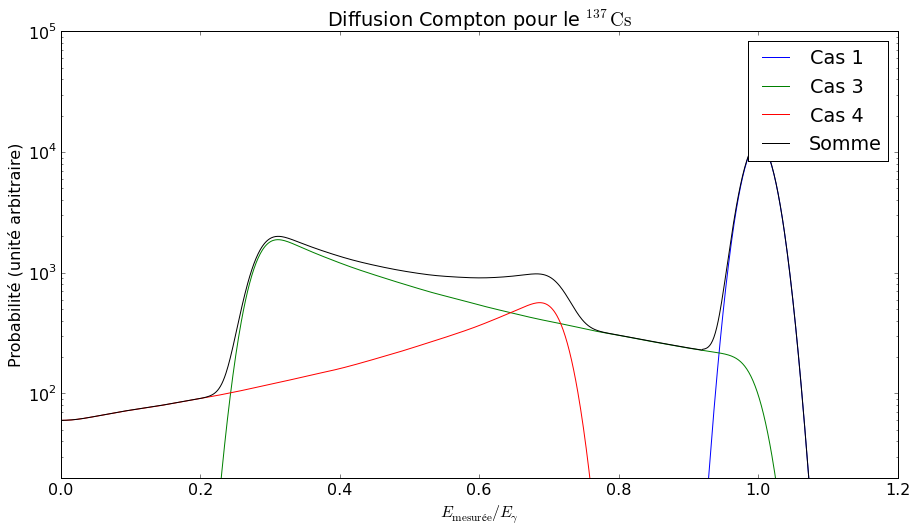

In [7]:
E = 661
bins = np.linspace(0, 1.2, 1200)
N = int(1e6)

prop = np.random.rand(N)

plt.figure(figsize = (15.0, 8.0))

peak = bins.copy()[:-1]
peak[1000] = 0.6 * N
plt.semilogy(bins[:-1], gaussian_filter(peak, sigma=20))

costheta = 1 - 2*np.random.rand(N)
egamma = 511/(511+E*(1-costheta))
egammaCount, egammaEdges = np.histogram(egamma, bins=bins, weights=prop)
plt.semilogy(bins[:-1], gaussian_filter(egammaCount, sigma=20))

costheta = 1 - 2*np.random.rand(N)
ee = 1 - 511/(511+E*(1-costheta))
eeCount, eeEdges = np.histogram(ee, bins=bins, weights=1-prop)
eeCount *= 0.3
plt.semilogy(bins[:-1], gaussian_filter(eeCount, sigma=20))

total = egammaCount + eeCount + peak
plt.semilogy(bins[:-1], gaussian_filter(total, sigma=20), color='black')

plt.title('Diffusion Compton pour le ${}^{137}\mathrm{Cs}$')
plt.xlabel('$E_\mathrm{mesurée}/E_\gamma$')
plt.ylabel('Probabilité (unité arbitraire)')
plt.ylim((20, 1e5))
plt.legend(('Cas 1', 'Cas 3', 'Cas 4', 'Somme'))

Un "plateau Compton" étant associé à chaque pic du spectre, celui-ci peut devenir assez compliqué (comme vous pourrez le voir avec le sodium 22).

## Bruit

Contribution dans le bruit.

/data/anaconda3/lib/python3.5/site-packages/pandas/core/index.py:6031: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  result = result.union(other)


(0, 0.05)

/data/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


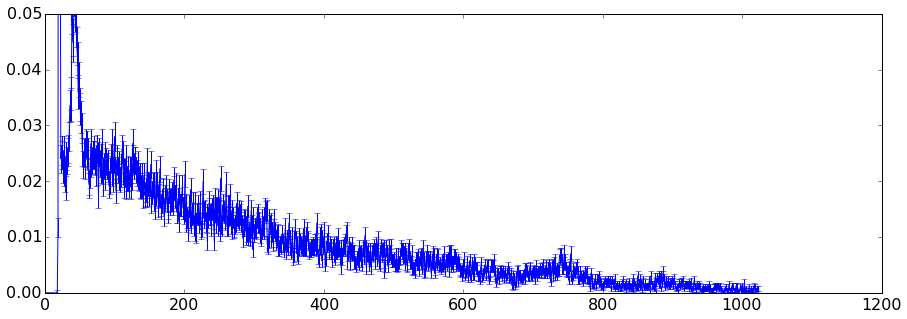

In [8]:
fileBr = codecs.open('data/BRUIT.A01', encoding = "ISO-8859-1")

df_br = read_file(fileBr)                
plt.errorbar(df_br.channel, df_br.N, yerr=df_br.NEr, label="Bruit")
plt.ylim(0, 0.05)

/data/anaconda3/lib/python3.5/site-packages/pandas/core/index.py:6031: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  result = result.union(other)


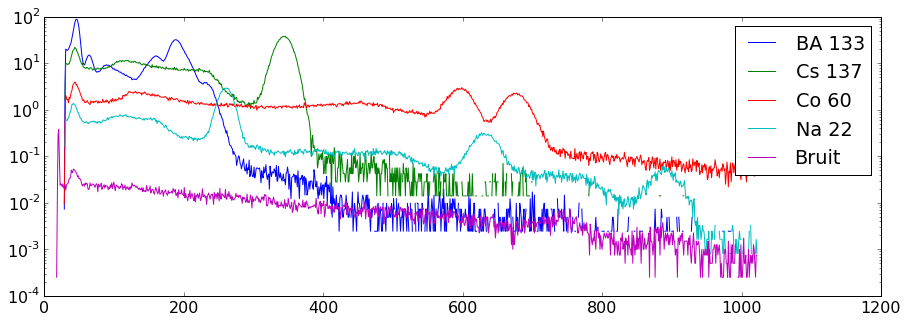

In [9]:
fileBa = codecs.open('data/BA133.A01', encoding = "ISO-8859-1")
fileCs = codecs.open('data/CS137.A01', encoding = "ISO-8859-1")
fileCo = codecs.open('data/CO60.A01', encoding = "ISO-8859-1")
fileNa = codecs.open('data/NA22.A01', encoding = "ISO-8859-1")

df_ba = read_file(fileBa)                
plt.semilogy(df_ba.channel, df_ba.N, label="BA 133")
df_cs = read_file(fileCs)                
plt.semilogy(df_cs.channel, df_cs.N, label="Cs 137")
df_co = read_file(fileCo)                
plt.semilogy(df_co.channel, df_co.N, label="Co 60")
df_na = read_file(fileNa)                
plt.semilogy(df_na.channel, df_na.N, label="Na 22")

fileBr = codecs.open('data/BRUIT.A01', encoding = "ISO-8859-1")

df_br = read_file(fileBr)                
plt.semilogy(df_br.channel, df_br.N, label="Bruit")
plt.legend()


#plt.show()

{'mean_er': 0.04888712413733767, 'sigma': 12.169371256453374, 'energy': 661, 'sigma_er': 0.03909913090470202, 'mean': 343.56510183212293}
{'mean_er': 0.12745235458438134, 'sigma': 19.50503978102552, 'energy': 1173, 'sigma_er': 0.14910143116497288, 'mean': 595.63329453615222}
{'mean_er': 0.16705083269354526, 'sigma': 18.461701409221664, 'energy': 1332, 'sigma_er': 0.2408293171054973, 'mean': 675.45650947421541}
{'mean_er': 0.04868103531387872, 'sigma': 10.501103128939393, 'energy': 511, 'sigma_er': 0.05541489255217905, 'mean': 260.45416560879232}
{'mean_er': 0.20803890092140462, 'sigma': 19.28187415729646, 'energy': 1274, 'sigma_er': 0.2588707099734311, 'mean': 631.66780233373174}
{'mean_er': 0.07709071223437464, 'sigma': 6.2336356730295508, 'energy': 80, 'sigma_er': 0.132490014148686, 'mean': 42.74840287598068}


/data/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


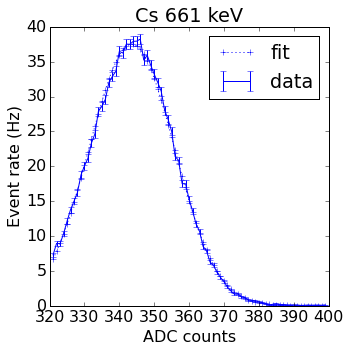

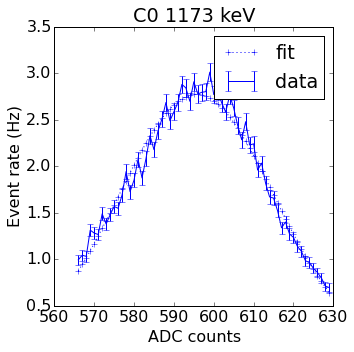

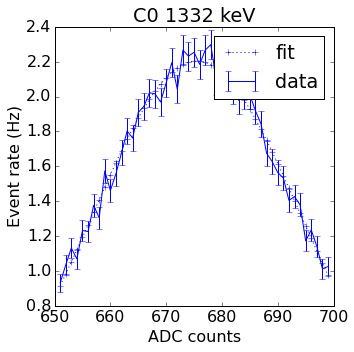

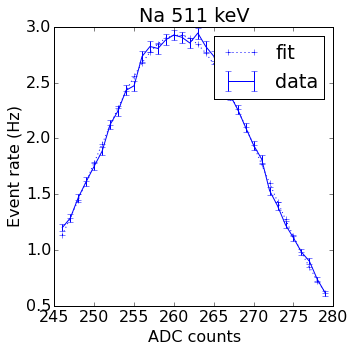

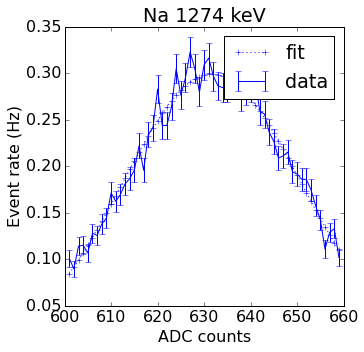

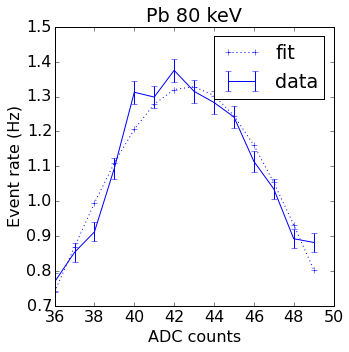

In [10]:
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy import asarray as ar,exp

import math
def gaus(x,a,x0,sigma):
    if sigma<0 :
        return -100000
    return a*exp(-(x-x0)**2/(2*sigma**2))

def line(x, a, b):
    return a+b*x

def get_peaks_resolution(data, start, end, title, energy):
# print(data)
    selected = data.loc[data['channel']>start]
    selected = selected.loc[selected['channel']<end]
    x = selected.channel
    y = selected.N
    y_err = selected.NEr
    popt,pcov = curve_fit(gaus,x,y, sigma= y_err, p0=[1, (end-start)/2.+start, 20], absolute_sigma=True)
    result = {'mean': popt[1], 'mean_er':math.sqrt(pcov[1][1]),
              'sigma': popt[2], 'sigma_er':math.sqrt(pcov[2][2]), 
              "energy": energy}
              
        
    print(result)
    plt.errorbar(x,y, yerr= [val for val in  y_err], label='data')
    #plt.plot(x,y, 'ro:',label='data')
   
    plt.plot(x,gaus(x,*popt),'b+:',label='fit')
    plt.legend()
    plt.title(title)
    plt.ylabel('Event rate (Hz)')
    plt.xlabel('ADC counts')
    return result
  
res = []

fig1 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_cs,320, 400, "Cs 661 keV", 661))
fig2 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_co,565, 630, "C0 1173 keV", 1173))
fig3 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_co,650, 700, "C0 1332 keV", 1332))
fig4 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_na,245, 280, "Na 511 keV", 511))
fig5 = plt.figure(figsize = (5.0, 5.0))

res.append(get_peaks_resolution(df_na,600, 660, "Na 1274 keV", 1274))
fig5 = plt.figure(figsize = (5.0, 5.0))
res.append(get_peaks_resolution(df_na,35, 50, "Pb 80 keV", 80))
#res.append(get_peaks_resolution(df_ba,180, 220, "Ba 288 keV", 288))

#print(res[:]['mean'])

#plt.plot(result['mean'],result['energy'])

[ 4.48558099  0.50569836]
[[  2.15549365e+01  -2.94238254e-02]
 [ -2.94238254e-02   5.07205397e-05]]


/data/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


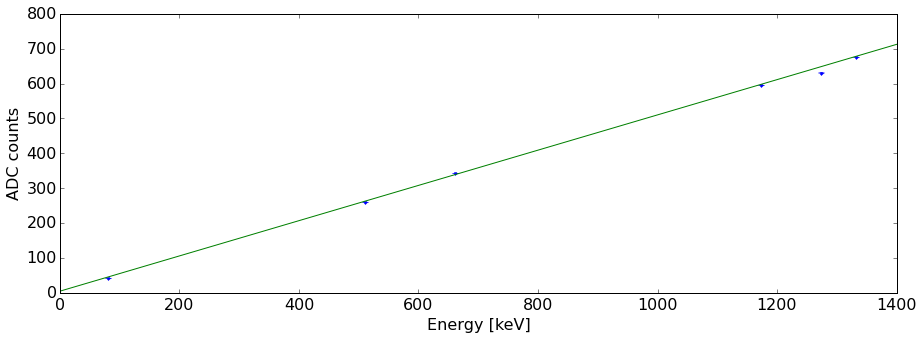

In [11]:
means = [r['mean'] for r in res]
mean_er = [r['mean_er'] for r in res]
en = [r['energy'] for r in res]

params, cov= curve_fit(line, en, means, sigma=mean_er)

plt.errorbar(en, means,yerr=mean_er, fmt='.')
x = np.linspace(0, 1400, 200)
plt.plot(x, line(x,params[0], params[1]))
plt.ylabel("ADC counts")
plt.xlabel("Energy [keV]")

print(params)
print(cov)

/data/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


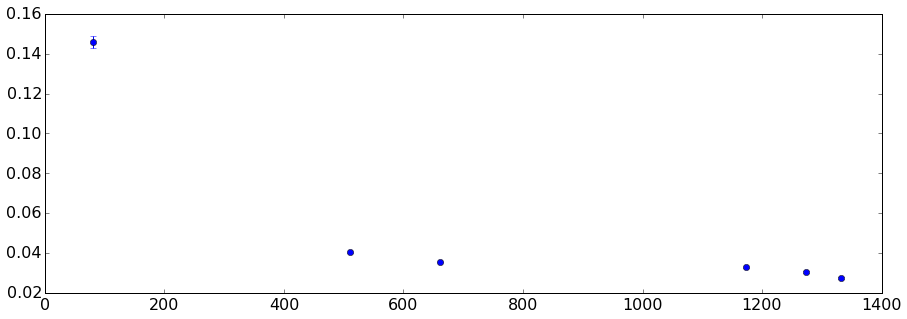

In [12]:
sigma = [r['sigma']/r['mean'] for r in res]
sigma_er = [r['sigma_er']/r['mean'] for r in res]
#en = [r['energy'] for r in res]

params, cov= curve_fit(line, en, means)
#print(params, cov)
plt.errorbar(en, sigma,yerr=sigma_er, fmt='o')
x = np.linspace(200, 1400, 200)
#plt.plot(x, line(x,params[0], params[1]))
#plt.plot(sp.linspace(200,1400), means,yerr=mean_er, fmt='o')


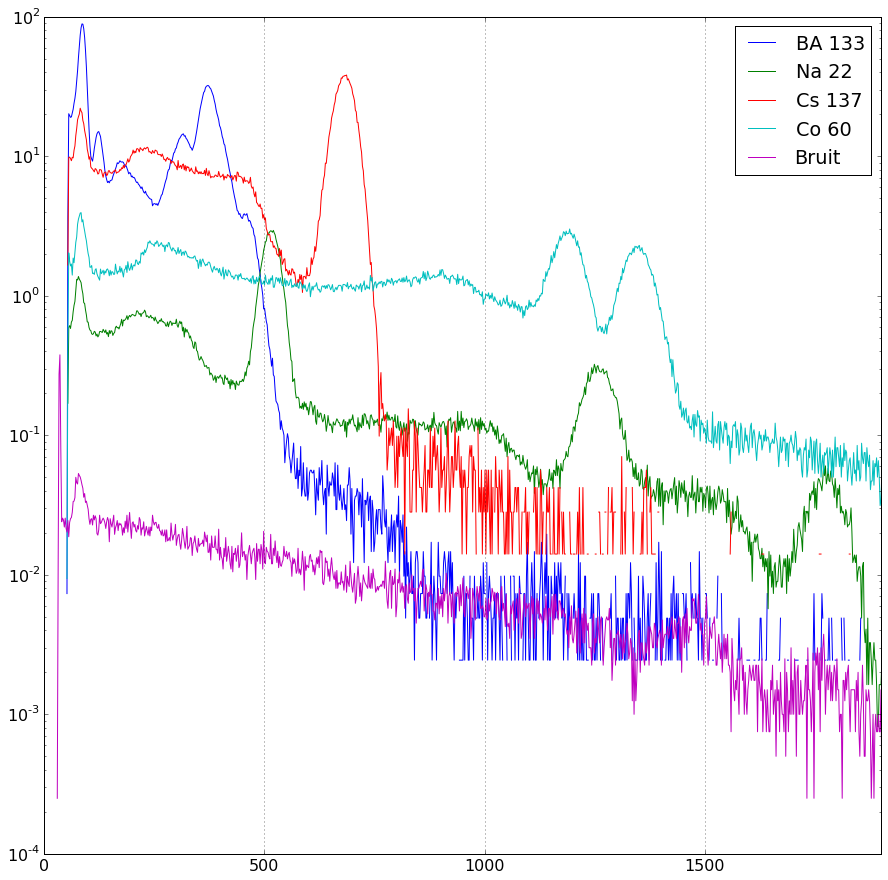

In [13]:
plt.figure(figsize = (15.0, 15.0))    # resize plots-
cal_ba = df_ba.copy()
cal_ba['channel']= cal_ba['channel']/params[1]-params[0]
plt.semilogy(cal_ba.channel, cal_ba.N, label="BA 133")
cal_na = df_na.copy()
cal_na['channel']= cal_na['channel']/params[1]-params[0]
plt.semilogy(cal_na.channel, cal_na.N, label="Na 22")
cal_cs = df_cs.copy()
cal_cs['channel']= cal_cs['channel']/params[1]-params[0]
plt.semilogy(cal_cs.channel, cal_cs.N, label="Cs 137")
cal_co = df_co.copy()
cal_co['channel']= cal_co['channel']/params[1]-params[0]
plt.semilogy(cal_co.channel, cal_co.N, label="Co 60")

cal_br = df_br.copy()
cal_br['channel']= cal_br['channel']/params[1]-params[0]
plt.semilogy(cal_br.channel, cal_br.N, label="Bruit")


plt.grid(axis="x")
plt.xlim(0, 1900)
plt.legend()

## Calibration du détecteur

## Mesure du temps du vie

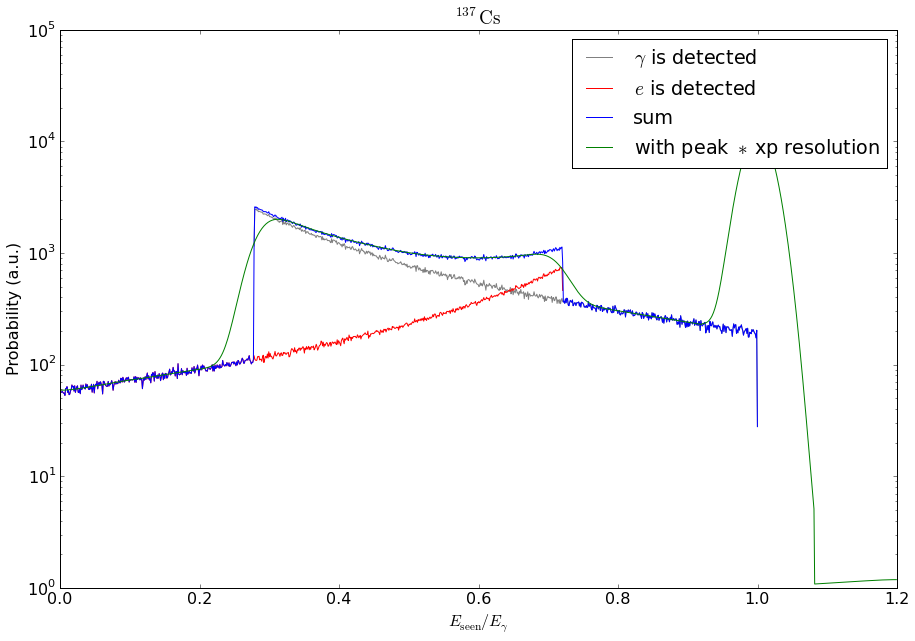

In [14]:
E = 661
bins = np.linspace(0, 1.2, 1200)
N = int(1e6)

prop = np.random.rand(N)

plt.figure(figsize = (15.0, 10.0))

costheta = 1 - 2*np.random.rand(N)
egamma = 511/(511+E*(1-costheta))
egammaCount, egammaEdges = np.histogram(egamma, bins=bins, weights=prop)
plt.semilogy(bins[:-1], egammaCount, color="gray")

costheta = 1 - 2*np.random.rand(N)
ee = 1 - 511/(511+E*(1-costheta))
eeCount, eeEdges = np.histogram(ee, bins=bins, weights=1-prop)
eeCount *= 0.3
plt.semilogy(bins[:-1], eeCount, color="red")

peak = bins.copy()[:-1]
peak[1000] = 0.6 * N

total = egammaCount + eeCount + peak

plt.semilogy(bins[:-1], total - peak)

from scipy.ndimage.filters import gaussian_filter
plt.semilogy(bins[:-1], gaussian_filter(total, sigma=20))

plt.title('${}^{137}\mathrm{Cs}$')
plt.xlabel('$E_\mathrm{seen}/E_\gamma$')
plt.ylabel('Probability (a.u.)')
plt.legend(('$\gamma$ is detected', '$e$ is detected', 'sum', 'with peak $*$ xp resolution'))